# Formaldehyde - AURA OMI

## Overview

- **Main ideas:**
    - Intensive operations that use a lot of RAM memory in the first run when we do not have a file for preprocessed data. After that, the operations are easier and do not require much RAM. Run this notebook in `aerossol` server.
    - Global data `(0.10 x 0.10º)` at `daily` time step from 2004-10-01 until now.
    - Use data for `Southestern Brazil` only.
    - Explore single `HDF5` data file for HCHO in the atmospheric column.
    - Compare data with its uncertainty for a single day.
    - Convert all data files from `HDF5` to `netcdf` if this was not done before.
    - Compare periods of different isolation rates for different years.

## Initial setup

In [1]:
%%time

# Load packages.
import sys
import os
import h5py
import glob
import warnings
import time
import progressbar

import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns

from dask.diagnostics import ProgressBar
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")
%matplotlib inline

CPU times: user 1.51 s, sys: 168 ms, total: 1.68 s
Wall time: 1.69 s


In [2]:
%%time

print(">>> Versions:")
print("* numpy:", np.__version__)
print("* pandas:", pd.__version__)
print("* xarray:", xr.__version__)
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"

>>> Versions:
* numpy: 1.19.1
* pandas: 1.1.1
* xarray: 0.16.0

>>> Computer:
* Hostname: aerossol
* User: sandroal
* Directory: /LFASGI/sandroal/notebooks/covid19
* Date: Sun Oct 18 20:59:42 GMT 2020
* CPUs: 24
CPU times: user 20 ms, sys: 40 ms, total: 60 ms
Wall time: 634 ms


In [3]:
# Main directory.
DATA_FOLDER = "/LFASGI/sandroal/data_sets/OMI/HCHO/L3_daily_010/"

# Where figures will be put.
FIG_PATH = "/LFASGI/sandroal/images/covid19/"

# Final results.
save_fig = True

# Map borders for Southeastern Brazil region.
loni, lonf, lati, latf = -55, -40, -30, -15

In [4]:
%%time

# My repository.
repository = "/LFASGI/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Work in progress.
import cdlearn

CPU times: user 1.4 s, sys: 108 ms, total: 1.51 s
Wall time: 1.57 s


In [5]:
%%time

# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 31.6 ms


In [6]:
# All hdf5 data files. The extension is "nc" but data files are "hdf5" really!
FILES = sorted(glob.glob(DATA_FOLDER + "/*.nc"))

print(">>>", len(FILES), "data files inside", DATA_FOLDER + ":")

for FILE in FILES[:5]:
    print("*", os.path.basename(FILE))
print("...")
for FILE in FILES[-5:]:
    print("*", os.path.basename(FILE))

>>> 5817 data files inside /LFASGI/sandroal/data_sets/OMI/HCHO/L3_daily_010/:
* OMI-Aura_L3-OMHCHOd_2004m1001_v003-2019m0725t193741.nc
* OMI-Aura_L3-OMHCHOd_2004m1002_v003-2019m0725t194204.nc
* OMI-Aura_L3-OMHCHOd_2004m1003_v003-2019m0725t193929.nc
* OMI-Aura_L3-OMHCHOd_2004m1004_v003-2019m0725t194624.nc
* OMI-Aura_L3-OMHCHOd_2004m1005_v003-2019m0725t194148.nc
...
* OMI-Aura_L3-OMHCHOd_2020m1008_v003-2020m1009t081256.nc
* OMI-Aura_L3-OMHCHOd_2020m1009_v003-2020m1010t071857.nc
* OMI-Aura_L3-OMHCHOd_2020m1010_v003-2020m1011t081947.nc
* OMI-Aura_L3-OMHCHOd_2020m1011_v003-2020m1012t092032.nc
* OMI-Aura_L3-OMHCHOd_2020m1012_v003-2020m1013t081227.nc


## Explore single h5 data file

In [7]:
# Display contents of a file.
!h5dump --contents {FILES[-1]}

HDF5 "/LFASGI/sandroal/data_sets/OMI/HCHO/L3_daily_010/OMI-Aura_L3-OMHCHOd_2020m1012_v003-2020m1013t081227.nc" {
FILE_CONTENTS {
 group      /
 group      /key_science_data
 dataset    /key_science_data/column_amount
 dataset    /key_science_data/column_uncertainty
 dataset    /latitude
 dataset    /longitude
 group      /qa_statistics
 dataset    /qa_statistics/data_quality_flag
 dataset    /qa_statistics/num_samples
 group      /support_data
 dataset    /support_data/albedo
 dataset    /support_data/amf
 dataset    /support_data/cloud_fraction
 dataset    /support_data/cloud_pressure
 dataset    /support_data/sample_weight
 dataset    /support_data/terrain_height
 }
}


## hdf2netcd function

In [8]:
# Auxiliary function.
def make_xarray_dataset(
    HDF5_DATA_FILE,
    DATASETS=["/key_science_data/column_amount", "/key_science_data/column_uncertainty"]
    ):

    # Create a new file object.
    f = h5py.File(name=HDF5_DATA_FILE, mode="r")

    # HDF5 dataset objects.
    HCHODS = f[DATASETS[0]]
    HCHOUNDS = f[DATASETS[1]]

    LATDS = f["/latitude"]
    LONDS = f["/longitude"]

    # Extract data as a numpy arrays.
    HCHODATA = HCHODS[:]
    HCHOUNDATA = HCHOUNDS[:]

    # Put nan for invalid values.
    mask_nan = HCHODATA == HCHODS.fillvalue
    HCHODATA[mask_nan] = np.nan

    mask_nan_un = HCHOUNDATA == HCHOUNDS.fillvalue
    HCHOUNDATA[mask_nan_un] = np.nan

    # Only positive concentrations.
    HCHODATA[HCHODATA < 0] = 0
    HCHOUNDATA[HCHOUNDATA < 0] = 0

    # Latitude and longitude grid points.
    LATDATA = LATDS[:]
    LONDATA = LONDS[:]

    # Point in time.
    TIME_POINT = np.datetime64(f.attrs["RangeBeginningDate"].astype(str))

    # Put data as xarray DataSet object.
    DataSet = xr.Dataset(
        data_vars={"HCHO": (("lat", "lon"), HCHODATA), 
                   "HCHO_UNCERTAINTY": (("lat", "lon"), HCHOUNDATA)},
        coords={"time": TIME_POINT, "lat": LATDATA, "lon": LONDATA}
    )

    # Global attributes.
    DataSet = DataSet.assign_attrs({
        "DataSetQuality": f.attrs["DataSetQuality"].astype(str), 
        "source": f.attrs["source"].astype(str),
        "DayOfYear": f.attrs["DayOfYear"].astype(str),
        "title": f.attrs["title"].astype(str),
        "history": f.attrs["history"].astype(str)
    })

    # Specific attributes.
    DataSet["HCHO"] = DataSet.HCHO.assign_attrs({
        "comment": HCHODS.attrs["comment"].astype(str),
        "units": HCHODS.attrs["units"].astype(str),
        "long_name": HCHODS.attrs["long_name"].astype(str),
    })

    DataSet["HCHO_UNCERTAINTY"] = DataSet.HCHO_UNCERTAINTY.assign_attrs({
        "comment": HCHOUNDS.attrs["comment"].astype(str),
        "units": HCHOUNDS.attrs["units"].astype(str),
        "long_name": HCHOUNDS.attrs["long_name"].astype(str),
    })
    
    f.close()

    return DataSet

## Data and its uncertainty for a single day

In [9]:
%%time

# Random data file.
DS = make_xarray_dataset(HDF5_DATA_FILE=np.random.choice(FILES))
print(DS)

<xarray.Dataset>
Dimensions:           (lat: 1800, lon: 3600)
Coordinates:
    time              datetime64[ns] 2009-03-08
  * lat               (lat) float32 -89.95 -89.85 -89.75 ... 89.84726 89.94726
  * lon               (lon) float32 -179.95 -179.84999 ... 179.87196 179.97197
Data variables:
    HCHO              (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    HCHO_UNCERTAINTY  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    DataSetQuality:  OMHCHOd dataset has been computed after excluding level ...
    source:          OMI
    DayOfYear:       067
    title:           OMI/Aura Formaldehyde (HCHO) Total Column Daily L3 Weigh...
    history:         2019m0726t033214Z; Original file created by OMI SIPS
CPU times: user 292 ms, sys: 60 ms, total: 352 ms
Wall time: 3.12 s


In [10]:
print(">>> Data")
print("* Mean: \t%.4e" %(DS.HCHO.mean().values))
print("* Median:\t%.4e" %(DS.HCHO.median().values))
print("* Max:  \t%.4e" %(DS.HCHO.max().values))
print("\n>>> Uncertainty")
print("* Mean: \t%.4e" %(DS.HCHO_UNCERTAINTY.mean().values))
print("* Median:\t%.4e" %(DS.HCHO_UNCERTAINTY.median().values))
print("* Max:  \t%.4e" %(DS.HCHO_UNCERTAINTY.max().values))

>>> Data
* Mean: 	4.2750e+15
* Median:	3.0577e+15
* Max:  	3.9771e+17

>>> Uncertainty
* Mean: 	5.8204e+15
* Median:	4.3282e+15
* Max:  	2.7886e+18


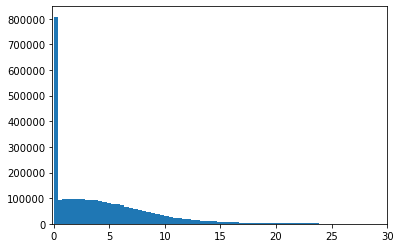

In [11]:
# Range of valid data.
scale = 1e15
plt.hist(DS.HCHO.values.flatten() / scale, bins=1000)
plt.xlim((-0.1, 30));

CPU times: user 22.8 s, sys: 2.03 s, total: 24.8 s
Wall time: 28.4 s


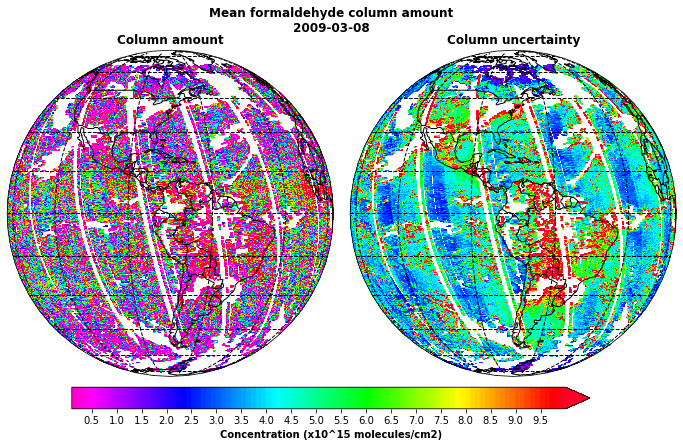

In [12]:
%%time

# Overall figure.
fig = plt.figure(figsize=(12, 6))

# Two global maps.
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(-75, 0))
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Orthographic(-75, 0))

# Common properties.
for axis in [ax1, ax2]:
    axis.set_global()
    axis.coastlines()
    axis.add_feature(cfeature.BORDERS)  

# Meridians and parallels. 
gl1 = ax1.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=False,
    xlocs=np.arange(-180, 180, 30),
    ylocs=np.arange(-90, 90, 15),
    linewidth=1, 
    color="black", 
    linestyle="--"
)

# Meridians and parallels. 
gl2 = ax2.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=False,
    xlocs=np.arange(-180, 180, 30),
    ylocs=np.arange(-90, 90, 15),
    linewidth=1, 
    color="black", 
    linestyle="--"
)

# Data into first map.
plotmap1 = (DS.HCHO / scale).plot(
    ax=ax1, 
    transform=ccrs.PlateCarree(), 
    vmin=0.1, 
    vmax=10,
    levels=np.arange(0.1, 10 + 0.1, 0.1),
    cmap=plt.cm.gist_rainbow_r,
    add_colorbar=False,
)

# Data into second map.
plotmap2 = (DS.HCHO_UNCERTAINTY / scale).plot(
    ax=ax2, 
    transform=ccrs.PlateCarree(), 
    vmin=0.1, 
    vmax=10,
    levels=np.arange(0, 10 + 0.1, 0.1),
    cmap=plt.cm.gist_rainbow_r,
    add_colorbar=False,
)

# Commom color bar.
cbar_ax = fig.add_axes(rect=[0.20, 0.05, 0.60, 0.05])
cb = fig.colorbar(
    mappable=plotmap1, 
    cax=cbar_ax,
    extend="max",
    orientation="horizontal"
)
cb.set_label("Concentration (x10^15 molecules/cm2)", weight="bold")
cb.set_ticks(np.arange(0.5, 10, 0.5))

# Adjustments.
ax1.set_title("Column amount", weight="bold")
ax2.set_title("Column uncertainty", weight="bold")
plt.subplots_adjust(wspace=0.05)
fig.suptitle(
    "Mean formaldehyde column amount\n" + DS.time.values.astype(str)[:10], 
    weight="bold"
)

# Save figures.
plt.savefig(
    FIG_PATH + "hcho_omi.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

## Make netcdf files

**DANGER ZONE: It takes about 3.5 hours to convert all files. But it must be done just one time!**

In [13]:
%%time

print(">>> Making netcdf files ...")
time.sleep(1)
bar = progressbar.ProgressBar(max_value=len(FILES))

# Loop over all files.
for index, FILE_PATH in enumerate(FILES):
    
    # File path without extension.
    FILE_PATH_WE = os.path.splitext(FILE_PATH)[0]
    
    # Netcdf file path.
    FILE_PATH_NETCDF = FILE_PATH_WE + "_netcdf.nc4"
    
    # Continue only if data file does not exist yet.
    if not os.path.isfile(FILE_PATH_NETCDF): 

        # xarray DataSet object.
        DS = make_xarray_dataset(HDF5_DATA_FILE=FILE_PATH)
        
        # Export data as netcdf.
        DS.to_netcdf(path=FILE_PATH_NETCDF)
        
    else:
        pass
        
    bar.update(index) 

>>> Making netcdf files ...


 96% (5597 of 5817) |################### | Elapsed Time: 0:00:00 ETA:   0:00:00

CPU times: user 180 ms, sys: 140 ms, total: 320 ms
Wall time: 10.4 s


In [14]:
# All netcdf data files.
FILES_PATHS = sorted(glob.glob(DATA_FOLDER + "/*_netcdf.nc4"))

print(">>>", len(FILES_PATHS), "data files inside", DATA_FOLDER + ":")

for FILE_PATH in FILES_PATHS[:5]:
    print("*", os.path.basename(FILE_PATH))
print("...")
for FILE_PATH in FILES_PATHS[-5:]:
    print("*", os.path.basename(FILE_PATH))

>>> 5817 data files inside /LFASGI/sandroal/data_sets/OMI/HCHO/L3_daily_010/:
* OMI-Aura_L3-OMHCHOd_2004m1001_v003-2019m0725t193741_netcdf.nc4
* OMI-Aura_L3-OMHCHOd_2004m1002_v003-2019m0725t194204_netcdf.nc4
* OMI-Aura_L3-OMHCHOd_2004m1003_v003-2019m0725t193929_netcdf.nc4
* OMI-Aura_L3-OMHCHOd_2004m1004_v003-2019m0725t194624_netcdf.nc4
* OMI-Aura_L3-OMHCHOd_2004m1005_v003-2019m0725t194148_netcdf.nc4
...
* OMI-Aura_L3-OMHCHOd_2020m1008_v003-2020m1009t081256_netcdf.nc4
* OMI-Aura_L3-OMHCHOd_2020m1009_v003-2020m1010t071857_netcdf.nc4
* OMI-Aura_L3-OMHCHOd_2020m1010_v003-2020m1011t081947_netcdf.nc4
* OMI-Aura_L3-OMHCHOd_2020m1011_v003-2020m1012t092032_netcdf.nc4
* OMI-Aura_L3-OMHCHOd_2020m1012_v003-2020m1013t081227_netcdf.nc4


## Load data for Southeastern Brazil

**DANGER ZONE: It takes about 1.5 hours to stack all data. Do not load dat into memory because RAM is not enough (do not do this `DS = DS.load()`).**

In [15]:
# Preprocessed file path.
ppdata_fp = "/LFASGI/sandroal/data_sets/OMI/HCHO/" + \
            "ppdata_L3_daily_010_southeastern_brazil.nc"

In [16]:
%%time

# Do it if only necessary.
if not os.path.exists(ppdata_fp):

    # Lazy read.
    DS = xr.open_mfdataset(
        paths=FILES_PATHS,
        concat_dim="time",
        combine="nested",
        chunks={}
    )

    # Change order of dimensions.
    DS = DS.transpose("time", "lat", "lon")

    # Southeastern Brazil.
    DS = DS.sel(lat=slice(lati, latf), lon=slice(loni, lonf))

    # Export preprocessed data.
    DS.to_netcdf(path=ppdata_fp, mode="w")    
        
else:
    DS = xr.open_dataset(ppdata_fp)    
        
# Show it.
print(); print(DS)


<xarray.Dataset>
Dimensions:           (lat: 150, lon: 150, time: 5817)
Coordinates:
  * lat               (lat) float32 -29.950916 -29.850918 ... -15.051143
  * lon               (lon) float32 -54.94237 -54.842365 ... -40.041462
  * time              (time) datetime64[ns] 2004-10-01 2004-10-02 ... 2020-10-12
Data variables:
    HCHO              (time, lat, lon) float32 ...
    HCHO_UNCERTAINTY  (time, lat, lon) float32 ...
Attributes:
    DataSetQuality:  OMHCHOd dataset has been computed after excluding level ...
    source:          OMI
    DayOfYear:       275
    title:           OMI/Aura Formaldehyde (HCHO) Total Column Daily L3 Weigh...
    history:         2019m0725t193741Z; Original file created by OMI SIPS
CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 24.7 ms


In [17]:
print(DS.DataSetQuality)

OMHCHOd dataset has been computed after excluding level 2 observations with SZA > 70 and cloud fraction > 0.3 and including only the highest quality retrievals as characterized by the level 2 product quality flags. Further details can be found in the OMHCHOd.README file


In [18]:
# Mask infinite values.
mask_inf = np.isinf(DS.HCHO)
DS["HCHO"] = DS.HCHO.where(~mask_inf, other=np.nan)

In [19]:
# For interpolation. Gain factor along latitude and longitude.
# This means squares smaller by a gain**2 factor.
gain = 1
        
# Interpolated grid.
lat1 = DS.lat[0].values
lat2 = DS.lat[-1].values
lon1 = DS.lon[0].values
lon2 = DS.lon[-1].values
dlat = np.diff(DS.lat[:2].values) / gain
dlon = np.diff(DS.lon[:2].values) / gain
grid={
    "lat": np.arange(lat1, lat2 + dlat, dlat), 
    "lon": np.arange(lon1, lon2 + dlon, dlon)
}

## Mean for whole time range

In [20]:
# Box around São Paulo City.
box_lat_i = -25.0; box_lat_f = -22.0; box_lon_i = -48.0; box_lon_f = -45.0 
box_dlat = box_lat_f - box_lat_i
box_dlon = box_lon_f - box_lon_i
box_lat_slice = slice(box_lat_i, box_lat_f)
box_lon_slice = slice(box_lon_i, box_lon_f)

CPU times: user 1.65 s, sys: 520 ms, total: 2.17 s
Wall time: 2.21 s


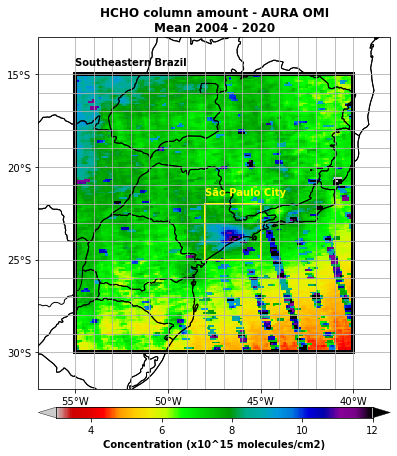

In [21]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(7, 7))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 1),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-57, -38, -32, -13], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )

# Mean for all time range available.
p = (DS.HCHO.mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=3,
    vmax=12,
    cmap=plt.cm.nipy_spectral_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="both")
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold")        

# Box around Southeast.
axgr[0].text(x=-55, y=-15 + 0.50, s="Southeastern Brazil", color="black", weight="bold")
axgr[0].add_patch(mpatches.Rectangle(
    xy=[-55, -30], 
    width=15, 
    height=15,
    fill=None,
    lw=4,
    edgecolor="black",
    facecolor="black"
))

# Box around São Paulo city.
axgr[0].text(x=box_lon_i, y=box_lat_f + 0.50, s="São Paulo City", color="yellow", weight="bold")
axgr[0].add_patch(mpatches.Rectangle(
    xy=[box_lon_i, box_lat_i], 
    width=box_dlon, 
    height=box_dlat,
    fill=None,
    lw=2,
    edgecolor="yellow",
    facecolor="yellow"
))
        
# Adjustments.
axgr[0].set_title(DS.HCHO.long_name + " - AURA OMI\nMean 2004 - 2020", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "hcho_time_mean.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Time series for whole time range

CPU times: user 1.19 s, sys: 592 ms, total: 1.78 s
Wall time: 1.84 s


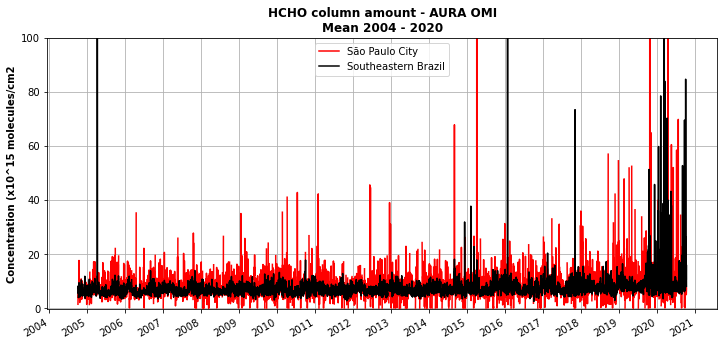

In [22]:
%%time

# Make figure and axis.
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

# São Paulo City
(DS.HCHO.sel(lat=box_lat_slice, lon=box_lon_slice).mean(dim=["lat", "lon"]) / scale).\
         plot(ax=axis, color="red", label="São Paulo City")

# Southeastern Brazil.
(DS.HCHO.mean(dim=["lat", "lon"]) / scale).\
         plot(ax=axis, color="black", label="Southeastern Brazil")

# Adjustments.
axis.set_ylim((-0.5, 100))
axis.set_ylabel("Concentration (x10^15 molecules/cm2", weight="bold")
axis.set_xlabel(None)
axis.xaxis.set_major_locator(mdates.YearLocator())
axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axis.grid()
axis.legend()
axis.set_title(DS.HCHO.long_name + " - AURA OMI\nMean 2004 - 2020", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "hcho_time_series_mean.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Define parameters for periods

In [23]:
%%time

# For selecting data. Keys are years and values are slices of date strings.
p0s = {}; p1s = {}; p2s = {}
p3s = {}; p4s = {}; p5s = {}; p6s = {}

# For titles in figures. Keys are years and values are strings.
t0s = {}; t1s = {}; t2s = {}
t3s = {}; t4s = {}; t5s = {}; t6s = {}

# Exclude 2004 because it begind in October.
for year in np.unique(DS.time.dt.year.values)[1: ]:
    
    # Same period for each year.
    p0s[year] = slice(str(year) + "-" + "02-12", str(year) + "-" + "03-13")
    t0s[year] = str(year) + "\nPeriod 0: February 12 - March 13"
    
    p1s[year] = slice(str(year) + "-" + "03-14", str(year) + "-" + "03-23")
    t1s[year] = str(year) + "\nPeriod 1: March 14 - March 23"

    p2s[year] = slice(str(year) + "-" + "03-24", str(year) + "-" + "04-03")
    t2s[year] = str(year) + "\nPeriod 2: March 24 - April 03"

    p3s[year] = slice(str(year) + "-" + "04-04", str(year) + "-" + "05-04")
    t3s[year] = str(year) + "\nPeriod 3: April 04 - May 04"

    p4s[year] = slice(str(year) + "-" + "05-05", str(year) + "-" + "06-05")
    t4s[year] = str(year) + "\nPeriod 4: May 05 - June 05"

    p5s[year] = slice(str(year) + "-" + "06-06", str(year) + "-" + "07-05")
    t5s[year] = str(year) + "\nPeriod 5: June 06 - July 05"

    p6s[year] = slice(str(year) + "-" + "07-06", str(year) + "-" + "08-05")
    t6s[year] = str(year) + "\nPeriod 6: July 06 - August 05"

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.97 ms


In [24]:
# Parameters for plots.
vmin = 0.0; vmax = 20.0; dv = 2 # Absolute concentrations.  
dvmin = -12.0; dvmax = 12.0; ddv = 3 # Variations.  

## Period 0: 12/02 - 13/03

CPU times: user 2.61 s, sys: 24 ms, total: 2.64 s
Wall time: 3.28 s


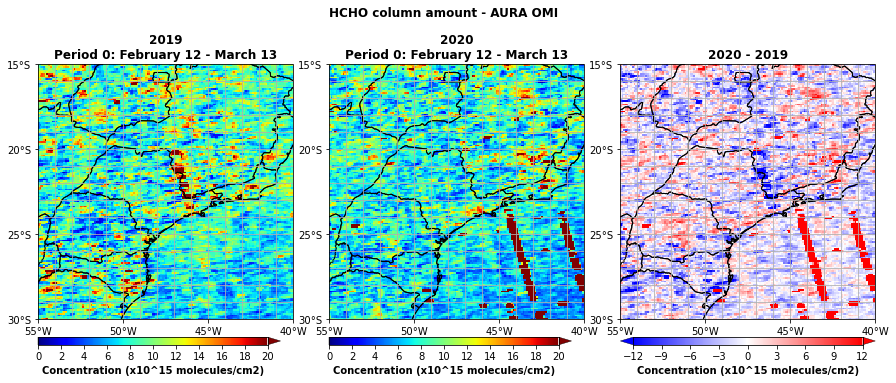

In [25]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 5.75))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Period 0 for 2019.
p = (DS.HCHO.sel(time=p0s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold")

# Period 0 for 2020.
p = (DS.HCHO.sel(time=p0s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.HCHO.sel(time=p0s[2020]).mean("time") / scale - \
     DS.HCHO.sel(time=p0s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 

# Adjustments.
fig.suptitle(DS.HCHO.long_name + " - AURA OMI", weight="bold")
axgr[0].set_title(t0s[2019], weight="bold")
axgr[1].set_title(t0s[2020], weight="bold")
axgr[2].set_title("2020 - 2019", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "hcho_p0_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 1: 14/03 - 23/03

CPU times: user 2.2 s, sys: 44 ms, total: 2.25 s
Wall time: 3.04 s


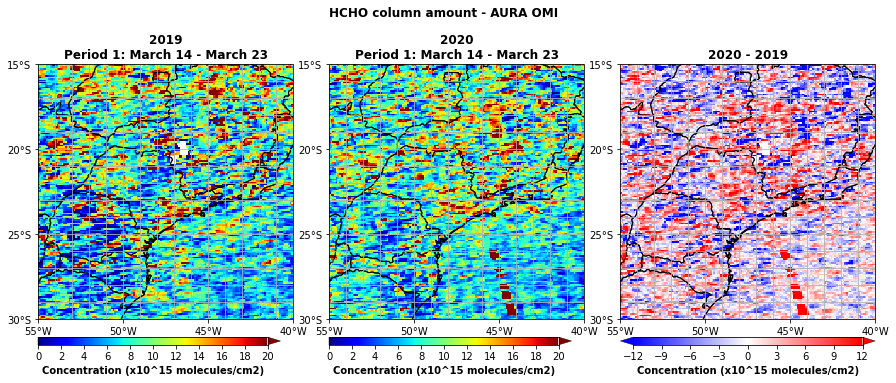

In [26]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 5.75))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Period 1 for 2019.
p = (DS.HCHO.sel(time=p1s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold")

# Period 1 for 2020.
p = (DS.HCHO.sel(time=p1s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.HCHO.sel(time=p1s[2020]).mean("time") / scale - \
     DS.HCHO.sel(time=p1s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 

# Adjustments.
fig.suptitle(DS.HCHO.long_name + " - AURA OMI", weight="bold")
axgr[0].set_title(t1s[2019], weight="bold")
axgr[1].set_title(t1s[2020], weight="bold")
axgr[2].set_title("2020 - 2019", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "hcho_p1_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 2: 24/03 - 03/04

CPU times: user 2.38 s, sys: 28 ms, total: 2.4 s
Wall time: 2.48 s


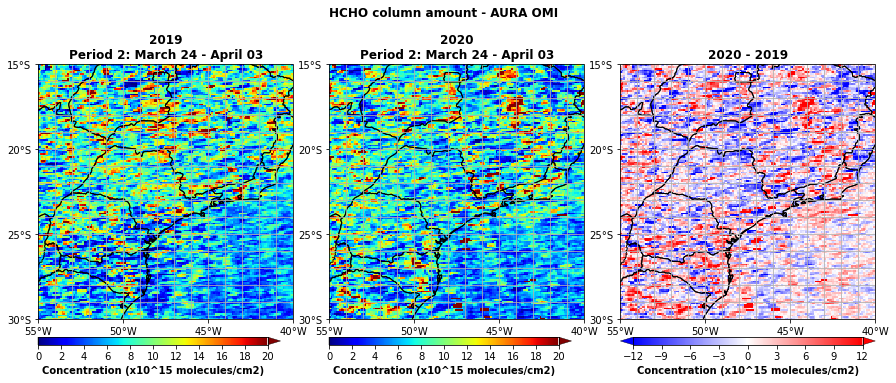

In [27]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 5.75))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Period 2 for 2019.
p = (DS.HCHO.sel(time=p2s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold")

# Period 2 for 2020.
p = (DS.HCHO.sel(time=p2s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.HCHO.sel(time=p2s[2020]).mean("time") / scale - \
     DS.HCHO.sel(time=p2s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 

# Adjustments.
fig.suptitle(DS.HCHO.long_name + " - AURA OMI", weight="bold")
axgr[0].set_title(t2s[2019], weight="bold")
axgr[1].set_title(t2s[2020], weight="bold")
axgr[2].set_title("2020 - 2019", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "hcho_p2_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 3: 04/04 - 04/05

CPU times: user 2.25 s, sys: 4 ms, total: 2.26 s
Wall time: 2.32 s


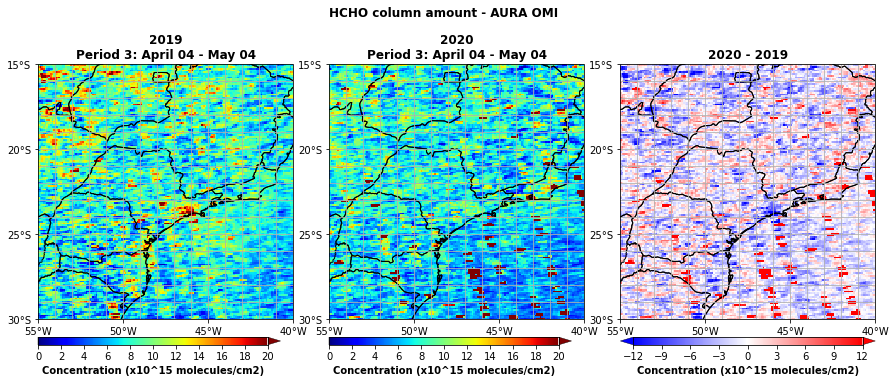

In [28]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 5.75))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Period 3 for 2019.
p = (DS.HCHO.sel(time=p3s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold")

# Period 3 for 2020.
p = (DS.HCHO.sel(time=p3s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.HCHO.sel(time=p3s[2020]).mean("time") / scale - \
     DS.HCHO.sel(time=p3s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 

# Adjustments.
fig.suptitle(DS.HCHO.long_name + " - AURA OMI", weight="bold")
axgr[0].set_title(t3s[2019], weight="bold")
axgr[1].set_title(t3s[2020], weight="bold")
axgr[2].set_title("2020 - 2019", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "hcho_p3_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 4: 05/05 - 05/06

CPU times: user 2.24 s, sys: 12 ms, total: 2.25 s
Wall time: 2.9 s


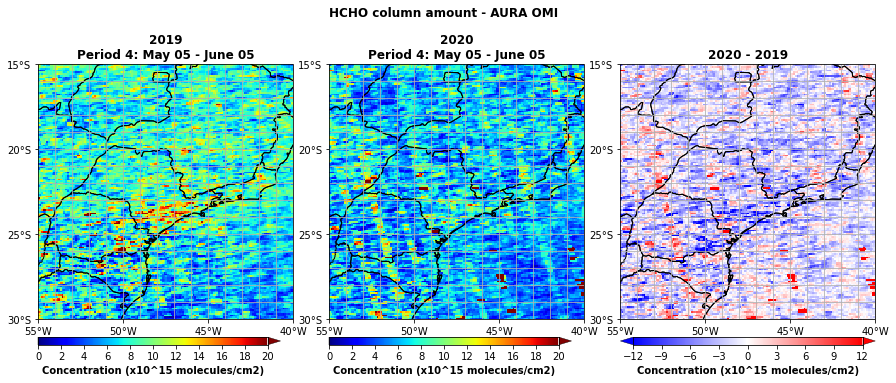

In [29]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 5.75))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Period 4 for 2019.
p = (DS.HCHO.sel(time=p4s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold")

# Period 4 for 2020.
p = (DS.HCHO.sel(time=p4s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.HCHO.sel(time=p4s[2020]).mean("time") / scale - \
     DS.HCHO.sel(time=p4s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 

# Adjustments.
fig.suptitle(DS.HCHO.long_name + " - AURA OMI", weight="bold")
axgr[0].set_title(t4s[2019], weight="bold")
axgr[1].set_title(t4s[2020], weight="bold")
axgr[2].set_title("2020 - 2019", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "hcho_p4_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 5: 06/06 - 05/07

CPU times: user 2.22 s, sys: 24 ms, total: 2.24 s
Wall time: 2.79 s


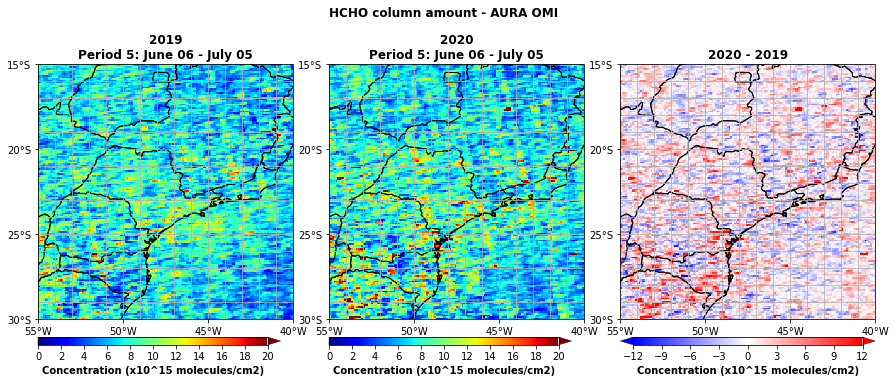

In [30]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 5.75))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Period 5 for 2019.
p = (DS.HCHO.sel(time=p5s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold")

# Period 5 for 2020.
p = (DS.HCHO.sel(time=p5s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.HCHO.sel(time=p5s[2020]).mean("time") / scale - \
     DS.HCHO.sel(time=p5s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 

# Adjustments.
fig.suptitle(DS.HCHO.long_name + " - AURA OMI", weight="bold")
axgr[0].set_title(t5s[2019], weight="bold")
axgr[1].set_title(t5s[2020], weight="bold")
axgr[2].set_title("2020 - 2019", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "hcho_p5_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 6: 06/07- 05/08

CPU times: user 2.31 s, sys: 16 ms, total: 2.32 s
Wall time: 2.64 s


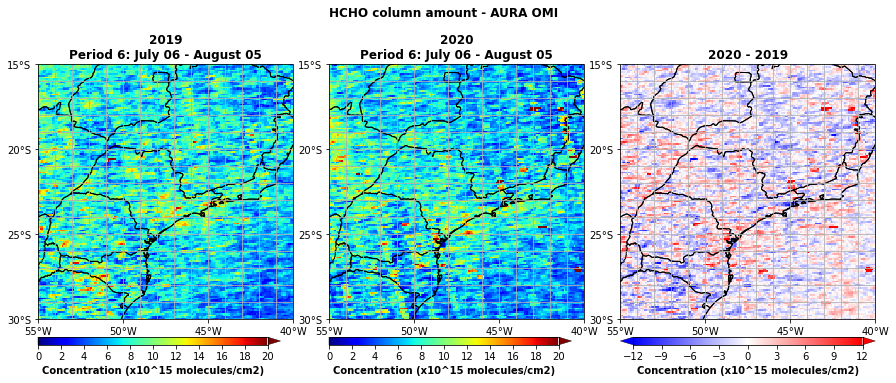

In [31]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 5.75))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Period 6 for 2019.
p = (DS.HCHO.sel(time=p6s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold")

# Period 6 for 2020.
p = (DS.HCHO.sel(time=p6s[2020]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + dv, dv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 
    
# Difference between 2020 and 2019 .
p = (DS.HCHO.sel(time=p6s[2020]).mean("time") / scale - \
     DS.HCHO.sel(time=p6s[2019]).mean("time") / scale).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.cbar_axis.set_ticks(np.arange(dvmin, dvmax + ddv, ddv))
cb.set_label_text("Concentration (x10^15 molecules/cm2)", weight="bold") 

# Adjustments.
fig.suptitle(DS.HCHO.long_name + " - AURA OMI", weight="bold")
axgr[0].set_title(t6s[2019], weight="bold")
axgr[1].set_title(t6s[2020], weight="bold")
axgr[2].set_title("2020 - 2019", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "hcho_p6_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Heatmaps

In [32]:
%%time

# Means as a pandas DataFrame object.
df_mean = pd.DataFrame()
df_mean_sp = pd.DataFrame()
periods = [p0s, p1s, p2s, p3s, p4s, p5s, p6s]
indexes = ["p0", "p1", "p2", "p3", "p4", "p5", "p6"]

# Exclude 2004 because it begind in October.
for year in np.unique(DS.time.dt.year.values)[1: ]:
    for period, index in zip(periods, indexes):
    
        # Get mean data for Southeastern Brazil.
        mean = (DS.HCHO.sel(time=period[year]).mean() / scale).values.flatten()
        df_mean.loc[index, str(year)] = mean
        
        # Get mean data of São Paulo City.
        mean_sp = (DS.HCHO.sel(time=period[year]).\
                           sel(lat=box_lat_slice, lon=box_lon_slice).\
                           mean() / scale).values.flatten()
        df_mean_sp.loc[index, str(year)] = mean_sp

CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.17 s


In [33]:
%%time

# Standard deviations as a pandas DataFrame object.
df_std = pd.DataFrame()
df_std_sp = pd.DataFrame()
periods = [p0s, p1s, p2s, p3s, p4s, p5s, p6s]
indexes = ["p0", "p1", "p2", "p3", "p4", "p5", "p6"]

# Exclude 2004 because it begind in October.
for year in np.unique(DS.time.dt.year.values)[1: ]:
    for period, index in zip(periods, indexes):
    
        # Get std data for Southeastern Brazil.
        std = (DS.HCHO.sel(time=period[year]).std() / scale).values.flatten()
        df_std.loc[index, str(year)] = std
        
        # Get std data of São Paulo City.
        std_sp = (DS.HCHO.sel(time=period[year]).\
                         sel(lat=box_lat_slice, lon=box_lon_slice).\
                         std() / scale).values.flatten()
        df_std_sp.loc[index, str(year)] = std_sp

CPU times: user 860 ms, sys: 0 ns, total: 860 ms
Wall time: 860 ms


In [34]:
%%time

# Medians as a pandas DataFrame object.
df_median = pd.DataFrame()
df_median_sp = pd.DataFrame()
periods = [p0s, p1s, p2s, p3s, p4s, p5s, p6s]
indexes = ["p0", "p1", "p2", "p3", "p4", "p5", "p6"]

# Exclude 2004 because it begind in October.
for year in np.unique(DS.time.dt.year.values)[1: ]:
    for period, index in zip(periods, indexes):
    
        # Get median data for Southeastern Brazil.
        median = (DS.HCHO.sel(time=period[year]).median() / scale).values.flatten()
        df_median.loc[index, str(year)] = median
        
        # Get median data of São Paulo City.
        median_sp = (DS.HCHO.sel(time=period[year]).\
                            sel(lat=box_lat_slice, lon=box_lon_slice).\
                            median() / scale).values.flatten()
        df_median_sp.loc[index, str(year)] = median_sp

CPU times: user 1.04 s, sys: 4 ms, total: 1.04 s
Wall time: 1.04 s


CPU times: user 1.25 s, sys: 80 ms, total: 1.33 s
Wall time: 1.44 s


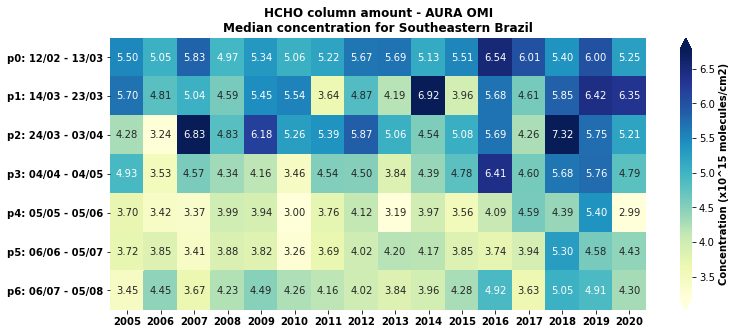

In [35]:
%%time

# Make figure.
plt.figure(figsize=(12, 5))
ax = sns.heatmap(
    data=df_median,
    cmap=plt.cm.YlGnBu,
    robust=True,
    annot=True,
    fmt=".2f",
    yticklabels=["p0: 12/02 - 13/03", 
                 "p1: 14/03 - 23/03",
                 "p2: 24/03 - 03/04",
                 "p3: 04/04 - 04/05",
                 "p4: 05/05 - 05/06",
                 "p5: 06/06 - 05/07",
                 "p6: 06/07 - 05/08"],
    cbar_kws={"extend": "both"}
)

# Adjustments.
ax.set_title(DS.HCHO.long_name + " - AURA OMI" + \
             "\nMedian concentration for Southeastern Brazil", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Concentration (x10^15 molecules/cm2)", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "hcho_heatmap_median.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.19 s, sys: 80 ms, total: 1.27 s
Wall time: 1.3 s


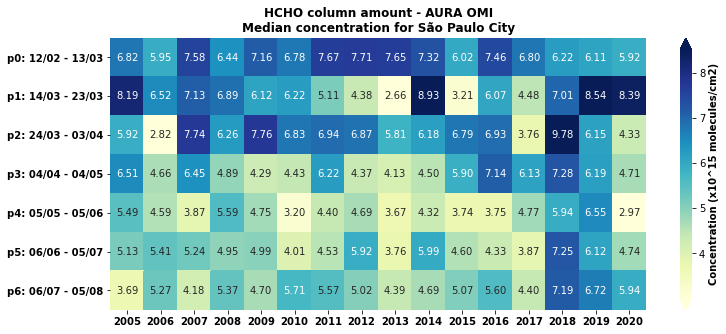

In [36]:
%%time

# Make figure.
plt.figure(figsize=(12, 5))
ax = sns.heatmap(
    data=df_median_sp,
    cmap=plt.cm.YlGnBu,
    robust=True,
    annot=True,
    fmt=".2f",
    yticklabels=["p0: 12/02 - 13/03", 
                 "p1: 14/03 - 23/03",
                 "p2: 24/03 - 03/04",
                 "p3: 04/04 - 04/05",
                 "p4: 05/05 - 05/06",
                 "p5: 06/06 - 05/07",
                 "p6: 06/07 - 05/08"],
    cbar_kws={"extend": "both"}
)

# Adjustments.
ax.set_title(DS.HCHO.long_name + " - AURA OMI" + \
             "\nMedian concentration for São Paulo City", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Concentration (x10^15 molecules/cm2)", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "hcho_heatmap_sp_city_median.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )